In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Using {device} as device')

Using cuda as device


In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(root = './data', train = True, transform = transform, download=True)
test_set = MNIST(root = './data', train = False, transform = transform, download=True)

In [4]:
from torch.utils.data import DataLoader

batch_size = 500
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [5]:
class Conv2d(nn.Module):
    def __init__(self):
        super(Conv2d, self).__init__() 
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size = 7, padding = 1, stride = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1),
            nn.Dropout(p = 0.2),
            nn.LeakyReLU(negative_slope = 0.01),

            nn.Conv2d(8, 16, kernel_size = 5, padding = 1, stride = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1),
            nn.Dropout(p = 0.2),
            nn.LeakyReLU(negative_slope = 0.01),

            nn.Flatten(),
            nn.Linear(5 * 5 * 16, 200),
            nn.Dropout(p = 0.5),
            nn.Linear(200, 10)
        )
    def forward(self, x):
        return self.layers(x)

In [6]:
def labels_encoding(labels):
    '''Returns tensor with one hot encoded labels, size = batch_size * 10'''
    labels_df = pd.Series(labels.clone().detach().cpu().numpy())
    labels_encoded_df = pd.get_dummies(labels_df)
    labels = torch.tensor(labels_encoded_df.values, dtype=float, device = device)
    return labels

def train_test_losses(train_losses: list, test_losses: list):
    '''Displays model losses'''
    from IPython import display

    # plot train and test losses
    plt.plot(train_losses, label='Train Loss', color = 'blue')
    plt.plot(test_losses, label='Test Loss', color = 'orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

def conv2D_classification(model, test_loader: DataLoader):
    '''Returns predicted and true classes for images in test dataset 
    (2 lists of numbers from 0 to 9)'''
    pred_val = []
    true_val = []

    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.detach().cpu().numpy()
        outputs = model(images).detach().cpu().numpy()

        for i in range(np.shape(outputs)[0]):
            array = outputs[i, :]
            number = np.argmax(array)
            pred_val.append(number)
            true_val.append(labels[i])

    return pred_val, true_val

def model_metrics(model, test_loader: DataLoader):
    '''Metrics for trained model 
    (f1_score, balanced_accuracy_score, ConfusionMatrixDisplay), 
    returns f1-score'''
    from sklearn.metrics import f1_score, balanced_accuracy_score, ConfusionMatrixDisplay

    pred_val, true_val = conv2D_classification(model, test_loader)
    print(f'F1 score = {f1_score(true_val, pred_val, average = "micro")}')
    print(f'Balanced accuracy score = {balanced_accuracy_score(true_val, pred_val)}')
    display = ConfusionMatrixDisplay.from_predictions(true_val, pred_val)

    return f1_score(true_val, pred_val, average = "micro")

In [7]:
def train_model(model, epochs: int, train_loader: DataLoader,
                       test_loader: DataLoader, learning_rate: int):
    '''Training and optimizing model'''
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    test_losses = []
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels_encoding(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / i
        train_losses.append(avg_loss)
        total_loss = 0

        with torch.no_grad():
            model.eval()
            for i, (images, labels) in enumerate(test_loader):

                images = images.to(device)
                labels = labels_encoding(labels)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()

        avg_loss = total_loss / i
        test_losses.append(avg_loss)

        train_test_losses(train_losses, test_losses)

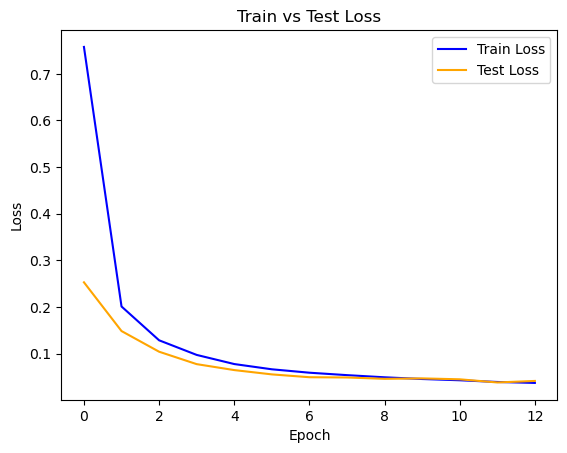

In [35]:
conv2d = Conv2d().to(device)

train_model(conv2d, 13, train_loader, test_loader, learning_rate = 0.001)

F1 score = 0.9884
Balanced accuracy score = 0.9884077899031556


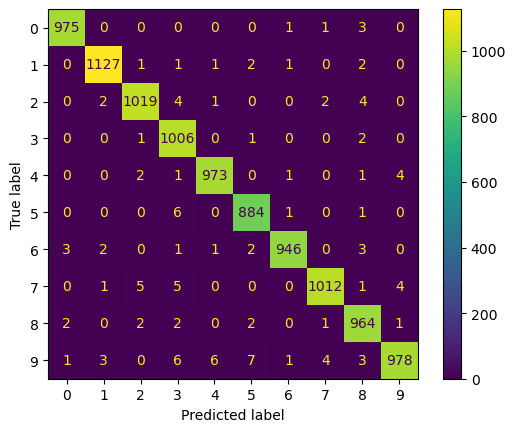

In [36]:
f_1_score = model_metrics(conv2d, test_loader)

torch.save(conv2d, f'conv2D_model(f1-score={f_1_score}).json')

In [8]:
from PIL import Image, ImageOps

def image_resize(image_filepath: str, hight: int, width: int):
    '''loading, resizing and displaying image'''
    img = Image.open(image_filepath)
    print(f"The size of the original image:{img.size}")

    transform_size = transforms.Resize(size = (hight, width))
    img = transform_size(img)
    img = ImageOps.invert(img)
    print(f"The size after resize:{img.size}")

    plt.imshow(img)
    plt.show()
    return img

def recognition(model_filepath: str, image_filepath: str, hight: int, width: int):
    '''image_resize function + prints number, recognized on image'''
    image = image_resize(image_filepath, hight, width)
    model = torch.load(model_filepath).to(device)
    transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
    img_tensor = transform(image).resize(1, 1, hight, width)

    output = model(img_tensor.to(device))
    print(f'Number on image: {np.argmax(output.detach().cpu().numpy())}')

The size of the original image:(1260, 1278)
The size after resize:(28, 28)


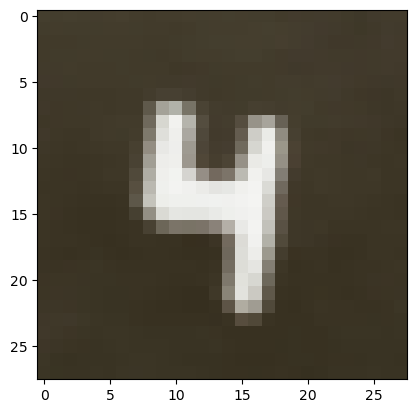

c:\Users\feawe\anaconda3\envs\networks\lib\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Number on image: 4


In [9]:
recognition('conv2D_model(f1-score=0.9884).json', 'handwritten-4.jpg', 28, 28)

The size of the original image:(1280, 1184)
The size after resize:(28, 28)


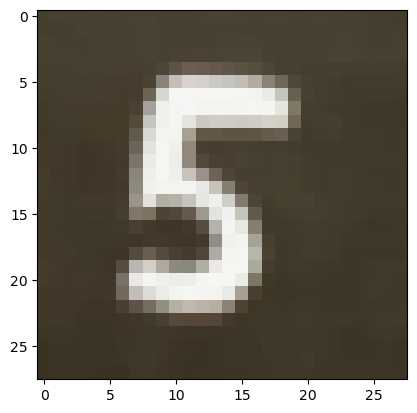

Number on image: 5


In [10]:
recognition('conv2D_model(f1-score=0.9884).json', 'handwritten-5.jpg', 28, 28)

The size of the original image:(1280, 1211)
The size after resize:(28, 28)


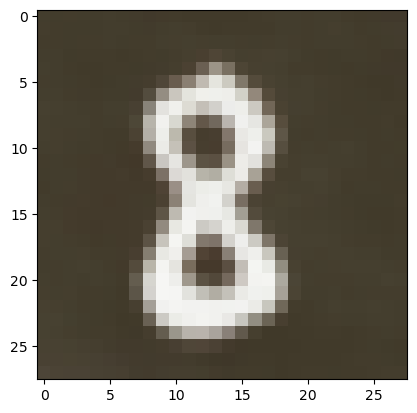

Number on image: 8


In [11]:
recognition('conv2D_model(f1-score=0.9884).json', 'handwritten-8.jpg', 28, 28)